In [1]:
import torch
import pytorch_lightning as pl
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from ray import air, tune
import ray
from ray.air.config import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.lightning import LightningTrainer, LightningConfigBuilder
import numpy as np
import os
import torch.nn.functional as F
from pytorch_lightning.callbacks import RichProgressBar
import tensorboard
import pandas as pd
from ray.tune.integration.pytorch_lightning import TuneReportCallback

/home/raffi/mambaforge/envs/opt4ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch Lightning Modules

### Data Module

In [2]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64, cwd=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = os.path.join(cwd, "data")
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, train=True, download=True)
        datasets.CIFAR10(root=self.data_path, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.cifar10_train = datasets.CIFAR10(root=self.data_path, train=True, transform=self.transform)
            self.cifar10_val = datasets.CIFAR10(root=self.data_path, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size, num_workers=1, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size, num_workers=1, shuffle=True)

### Networks

In [3]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        # Reduced the number of output channels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Reduced the input features of the fully connected layer
        self.fc1 = nn.Linear(32 * 16 * 16, 64) # reduced from 128 to 64
        self.fc2 = nn.Linear(64, 10) # output layer remains the same

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16) # match the number of output channels from conv2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
class SmallNetLightning(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        #self.model = torchvision.models.resnet18()
        self.model = SmallNet()
        #num_ftrs = self.model.fc.in_features
        #self.model.fc = nn.Linear(num_ftrs, 10)  # CIFAR10 has 10 classes
        self.loss = torch.nn.CrossEntropyLoss()
        self.training_step_outputs = []
        self.validation_step_outputs = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        # takes the constructor of the optimizer as input (for example torch.optim.Adam)
        return self.config["optimizer"](self.model.parameters(), **self.config["parameters"])


## Hyperparameter Search with Ray

In [5]:
def train(batch_size=64, epochs=10, config=None, accelerator="cuda" if torch.cuda.is_available() else "cpu", num_workers=1, cwd=None, logger_name="my_model", train_batches_per_epoch=0.1, val_batches_per_epoch=0.2):
    '''
    batch_size: batch size for training
    config: dictionary containing the optimizer and its parameters
    accelerator: "cuda" or "cpu"
    num_workers: number of parallel trials to run (each trial uses 1 cpu core and 1 gpu core, if available)
    cwd: current working directory
    logger_name: name of the directory (used for tensorboard and csv logs)
    train_batches_per_epoch: fraction of training data to use per epoch
    val_batches_per_epoch: fraction of validation data to use per epoch
    '''
    
    torch.manual_seed(42)
    
    data_module = CIFAR10DataModule(batch_size=batch_size, cwd=cwd)
    #logger = TensorBoardLogger(os.path.join(cwd,"tensorboard_logs"), name=logger_name)
    logger = CSVLogger(os.path.join(cwd,"csv_logs"), name=logger_name)
    #tune_logger = TuneReportCallback(["train_loss, val_loss"], on="on_test_epoch_end")
    
    lightning_config = (
        LightningConfigBuilder()
        .module(cls=SmallNetLightning, config=config)
        .trainer(max_epochs=epochs, accelerator=accelerator, logger=None, callbacks=[RichProgressBar(leave=True)], limit_train_batches=train_batches_per_epoch, limit_val_batches=val_batches_per_epoch)
        .fit_params(datamodule=data_module)
        #.checkpointing(monitor="val_loss", save_top_k=0, mode="min")
        .build()
    )

    run_config = RunConfig(
        # checkpoint_config=CheckpointConfig(
        #     num_to_keep=1,
        #     checkpoint_score_attribute="val_loss",
        #     checkpoint_score_order="min",
        #  ),
    )

    scaling_config = ScalingConfig(
        num_workers=num_workers, resources_per_worker={"CPU": 1, "GPU": 1 if accelerator=="cuda" else 0}
    )

    # Define a base LightningTrainer without hyper-parameters for Tuner
    lightning_trainer = LightningTrainer(
        scaling_config=scaling_config,
        run_config=run_config,
    )   

    tuner = tune.Tuner(
        lightning_trainer,
        param_space={"lightning_config": lightning_config},
        tune_config=tune.TuneConfig(
            max_concurrent_trials=1,
            metric="val_loss",
            mode="min",
            #num_samples=num_samples,
        ),
        run_config=air.RunConfig(
            storage_path=cwd,
            name="tune_cifar10",
        ),
    )
    results = tuner.fit()
    #best_result = results.get_best_result(metric="val_loss", mode="max")
    return results

## Example Experiment

In [6]:
ray.init(ignore_reinit_error=True)

"""
The tune gridsearch will try all possible combinations of the parameters in the config dictionary.
By using the np.logspace function we can define a range of values to try for each parameter.
The argument "num" defines the number of values to try in the range.
    
"""

config = {
    "optimizer": torch.optim.SGD,
    "parameters":{
        "lr": tune.grid_search(np.logspace(-1, -6, num=3)),
        "weight_decay": tune.grid_search(np.logspace(-1, -6, num=3)),
    }
}

result_grid = train(config=config, epochs=5, num_workers=1, cwd=os.path.join(os.getcwd()), logger_name="SmallNet", train_batches_per_epoch=0.01, val_batches_per_epoch=0.1)

2023-06-22 17:18:37,353	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(LightningTrainer pid=142730) 2023-06-22 17:19:55,254	INFO backend_executor.py:137 -- Starting distributed worker processes: ['143131 (192.168.2.113)']
(RayTrainWorker pid=143146) 2023-06-22 17:20:16,727	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(LightningTrainer pid=142689) 2023-06-22 17:19:57,568	INFO backend_executor.py:137 -- Starting distributed worker processes: ['143229 (192.168.2.113)'] [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=143170) 2023-06-22 17:20:24,511	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1] [repeated 2x across cluster]
(RayTrainWorker pid=143375) 2023-06-22 17:20:29,790	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1] [repeated 4x across cluster]
(RayTrainWorker

(RayTrainWorker pid=143146) Files already downloaded and verified


(RayTrainWorker pid=143245) GPU available: False, used: False [repeated 2x across cluster]
(RayTrainWorker pid=143245) TPU available: False, using: 0 TPU cores [repeated 2x across cluster]
(RayTrainWorker pid=143245) IPU available: False, using: 0 IPUs [repeated 2x across cluster]
(RayTrainWorker pid=143245) HPU available: False, using: 0 HPUs [repeated 2x across cluster]


(RayTrainWorker pid=143131) Files already downloaded and verified
(RayTrainWorker pid=143229) Files already downloaded and verified
(RayTrainWorker pid=143270) Files already downloaded and verified [repeated 3x across cluster]
(RayTrainWorker pid=143146) Files already downloaded and verified [repeated 3x across cluster]
(RayTrainWorker pid=143131) Files already downloaded and verified
(RayTrainWorker pid=143229) Files already downloaded and verified


(RayTrainWorker pid=143146) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_1f9d2_00004_4_lr=0.0003,weight_decay=0.0003_2023-06-22_17-19-05/rank_0/lightning_logs


(RayTrainWorker pid=143375) Files already downloaded and verified [repeated 3x across cluster]


(RayTrainWorker pid=143131) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_1f9d2_00006_6_lr=0.1000,weight_decay=0.0000_2023-06-22_17-19-05/rank_0/lightning_logs
(RayTrainWorker pid=143170) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_1f9d2_00007_7_lr=0.0003,weight_decay=0.0000_2023-06-22_17-19-05/rank_0/lightning_logs


(RayTrainWorker pid=143146) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
(RayTrainWorker pid=143146) ┃   ┃ Name  ┃ Type             ┃ Params ┃
(RayTrainWorker pid=143146) ┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
(RayTrainWorker pid=143146) │ 0 │ model │ SmallNet         │  530 K │
(RayTrainWorker pid=143146) │ 1 │ loss  │ CrossEntropyLoss │      0 │
(RayTrainWorker pid=143146) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=143146) Trainable params: 530 K                                                         
(RayTrainWorker pid=143146) Non-trainable params: 0                                                         
(RayTrainWorker pid=143146) Total params: 530 K                                                             
(RayTrainWorker pid=143146) Total estimated model params size (MB): 2                                       
(RayTrainWorker pid=143245) Files already downloaded and verified [repeated 2x across cluster]
(RayTrainWorker pid=143146) 
/home/raffi/mambafor

(RayTrainWorker pid=143146) E0622 17:22:01.689357891  143558 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=143245) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_1f9d2_00000_0_lr=0.1000,weight_decay=0.1000_2023-06-22_17-19-04/rank_0/lightning_logs [repeated 5x across cluster]


(RayTrainWorker pid=143146) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=143146) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=143146) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=143146) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=143146)   rank_zero_warn(
(RayTrainWorker pid=143146) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=143146) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=143146) value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=143146)   rank_zero_warn(
Epoch 0/4  ━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=143131) g/trainer/connectors/data_connector.py:480: Poss

(RayTrainWorker pid=143170) E0622 17:22:07.195655802  143596 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


(RayTrainWorker pid=143170) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, [repeated 2x across cluster]
(RayTrainWorker pid=143170) increasing the value of the `num_workers` argument` (try 16 which is the number  [repeated 2x across cluster]
(RayTrainWorker pid=143170) of cpus on this machine) in the `DataLoader` init to improve performance. [repeated 2x across cluster]
(RayTrainWorker pid=143170)   rank_zero_warn( [repeated 4x across cluster]
Epoch 0/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:05 • -:--:-- 0.00it/s v_num: 0 val_loss: 
Epoch 0/4  ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 1/7 0:00:05 • -:--:-- 0.00it/s v_num: 0 
(RayTrainWorker pid=143170) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=143170) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=143170) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=143270) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ [repeated 2x across cluster]
(RayTrainWorker pid=143270) ┃   ┃ Name  ┃ Type 

(RayTrainWorker pid=143264) E0622 17:22:15.118411235  143597 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


(RayTrainWorker pid=143264) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=143264) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=143264) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=143270)  [repeated 10x across cluster]
(RayTrainWorker pid=143270) Total params: 530 K                                                              [repeated 2x across cluster]
(RayTrainWorker pid=143264) 
(RayTrainWorker pid=143264) 
(RayTrainWorker pid=143264) 
(RayTrainWorker pid=143264) 
(RayTrainWorker pid=143131) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=143170) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=143170) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=143170) value for lo

(RayTrainWorker pid=143229) E0622 17:22:23.890140878  143595 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 7x across cluster]


Epoch 0/4  ━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=143245) 
(RayTrainWorker pid=143245) 
(RayTrainWorker pid=143245) 
(RayTrainWorker pid=143245) 
(RayTrainWorker pid=143245) 
(RayTrainWorker pid=143245) 
Sanity Checking ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:05 • 0:00:00 0.54it/s 
(RayTrainWorker pid=143229)   rank_zero_warn( [repeated 2x across cluster]
Sanity Checking ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 1/2 0:00:04 • -:--:-- 0.00it/s  [repeated 5x across cluster]
(RayTrainWorker pid=143245) g/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your 
(RayTrainWorker pid=143245) `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended 
(RayTrainWorker pid=143245) that you turn shuffling off for val/test dataloaders.
(RayTrainWorker pid=143245) val_dataloader, does not have many workers which may be a bottleneck. Consider 
(RayTrainWorker pid=143245) g/trainer/connectors/data_connector.py:432: PossibleUserWa

(RayTrainWorker pid=143270) E0622 17:22:30.153534986  143609 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 6x across cluster]


(RayTrainWorker pid=143264)   rank_zero_warn( [repeated 6x across cluster]
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 6/7 0:00:28 • 0:00:05 0.22it/s v_num: 0  [repeated 9x across cluster]
Epoch 0/4  ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 2/7 0:00:13 • 0:00:22 0.24it/s v_num: 0 
Epoch 0/4  ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 2/7 0:00:13 • 0:00:22 0.24it/s v_num: 0 
Epoch 0/4  ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 2/7 0:00:13 • 0:00:22 0.24it/s v_num: 0 
Epoch 0/4  ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 2/7 0:00:13 • 0:00:22 0.24it/s v_num: 0 
(RayTrainWorker pid=143264) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, [repeated 2x across cluster]
(RayTrainWorker pid=143264) increasing the value of the `num_workers` argument` (try 16 which is the number  [repeated 2x across cluster]
(RayTrainWorker pid=143264) of cpus on this machine) in the `DataLoader` init to improve performance. [repeated 2x across cluster]
(RayTrainWorker pid=143270) train_dataloader, does not have many workers which may b

(RayTrainWorker pid=143245) E0622 17:22:37.444595237  143625 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


(RayTrainWorker pid=143270) 
 [repeated 2x across cluster]
Epoch 0/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:10 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=143245) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=143245) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=143245) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=143245) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=143245) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=143245) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=143245) value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=143375)   rank_zero_warn( [repeated 4x across cluster]
Epoch 0/4  ━━━━━━━━━━━━━━━━╺━━━━━━

(RayTrainWorker pid=143170) E0622 17:22:53.536334426  143596 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 5x across cluster]


Epoch 0/4  ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 4/7 0:00:13 • 0:00:04 0.77it/s v_num: 0  [repeated 17x across cluster]
(RayTrainWorker pid=143375) Validation ━━━━━━━━━━━━━━━━━━━━╸━━━━━ 12/15 0:00:14 • 0:00:03 1.11it/s          
Epoch 0/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:34 • 0:00:00 0.21it/s v_num: 0 val_loss: 
(RayTrainWorker pid=143146)                                                              2.308 train_loss:  
(RayTrainWorker pid=143146)                                                              2.306              
(RayTrainWorker pid=143146) 


Trial name,_report_on,date,done,epoch,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,step,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
LightningTrainer_1f9d2_00000,train_epoch_end,2023-06-22_17-27-03,True,4,"0_lr=0.1000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,142686,True,35,436.934,28.6742,436.934,1687447622,2.27008,5,1f9d2_00000,2.25788
LightningTrainer_1f9d2_00001,train_epoch_end,2023-06-22_17-27-03,True,4,"1_lr=0.0003,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,142687,True,35,433.943,30.3714,433.943,1687447622,2.29978,5,1f9d2_00001,2.3021
LightningTrainer_1f9d2_00002,train_epoch_end,2023-06-22_17-27-02,True,4,"2_lr=0.0000,weight_decay=0.1000",thinkpad-t14s,5,192.168.2.113,142688,True,35,435.699,29.3269,435.699,1687447619,2.30811,5,1f9d2_00002,2.30443
LightningTrainer_1f9d2_00003,train_epoch_end,2023-06-22_17-27-06,True,4,"3_lr=0.1000,weight_decay=0.0003",thinkpad-t14s,5,192.168.2.113,142689,True,35,440.777,27.5254,440.777,1687447625,2.13699,5,1f9d2_00003,2.08175
LightningTrainer_1f9d2_00004,train_epoch_end,2023-06-22_17-26-43,True,4,"4_lr=0.0003,weight_decay=0.0003",thinkpad-t14s,5,192.168.2.113,142713,True,35,419.866,37.5094,419.866,1687447602,2.30244,5,1f9d2_00004,2.30782
LightningTrainer_1f9d2_00005,train_epoch_end,2023-06-22_17-27-05,True,4,"5_lr=0.0000,weight_decay=0.0003",thinkpad-t14s,5,192.168.2.113,142719,True,35,438.332,28.981,438.332,1687447624,2.30628,5,1f9d2_00005,2.30264
LightningTrainer_1f9d2_00006,train_epoch_end,2023-06-22_17-26-58,True,4,"6_lr=0.1000,weight_decay=0.0000",thinkpad-t14s,5,192.168.2.113,142730,True,35,436.253,33.6079,436.253,1687447612,2.17796,5,1f9d2_00006,2.13372
LightningTrainer_1f9d2_00007,train_epoch_end,2023-06-22_17-26-54,True,4,"7_lr=0.0003,weight_decay=0.0000",thinkpad-t14s,5,192.168.2.113,142819,True,35,430.849,30.8667,430.849,1687447607,2.31026,5,1f9d2_00007,2.30657
LightningTrainer_1f9d2_00008,train_epoch_end,2023-06-22_17-27-25,True,4,"8_lr=0.0000,weight_decay=0.0000",thinkpad-t14s,5,192.168.2.113,148327,True,35,15.1133,1.62515,15.1133,1687447645,2.30706,5,1f9d2_00008,2.30435


(RayTrainWorker pid=143131) Validation ━━━━━━━━━━━━━━━━━━━━━━╸━━━ 13/15 0:00:04 • 0:00:01 2.73it/s           [repeated 147x across cluster]
Epoch 0/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7  0:00:18 • 0:00:00 0.79it/s v_num: 0  [repeated 43x across cluster]
Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:01 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=143146)                                                              2.308 train_loss:  
(RayTrainWorker pid=143146)                                                              2.306              


(RayTrainWorker pid=143131) E0622 17:23:00.596943894  143582 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 4x across cluster]


Epoch 1/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:02 • 0:00:06 0.94it/s v_num: 0 val_loss:  [repeated 11x across cluster]
(RayTrainWorker pid=143131)                                                              2.29 train_loss:    [repeated 12x across cluster]
(RayTrainWorker pid=143131)                                                              2.297               [repeated 11x across cluster]
(RayTrainWorker pid=143245) Validation ━━━━━━━━━━━━━━━━━━━╺━━━━━━ 11/15 0:00:05 • 0:00:02 2.11it/s           [repeated 179x across cluster]
Epoch 1/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s  [repeated 36x across cluster]
Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:01 • -:--:-- 0.00it/s v_num: 0 val_loss:  [repeated 2x across cluster]


(RayTrainWorker pid=143245) E0622 17:23:06.206710109  143625 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 6x across cluster]


Epoch 1/4  ━━━━━━━━━━━━╸━━━━━ 5/7 0:00:03 • 0:00:02 1.59it/s v_num: 0 val_loss:  [repeated 71x across cluster]
(RayTrainWorker pid=143146)                                                               2.308 train_loss:  [repeated 95x across cluster]
(RayTrainWorker pid=143146)                                                               2.306              [repeated 76x across cluster]
(RayTrainWorker pid=143146) Validation ━━━━━━━━━╸━━━━━━━━ 8/15 0:00:02 • 0:00:03 3.12it/s                    [repeated 39x across cluster]
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:06 • 0:00:00 1.23it/s v_num: 0 val_loss: [repeated 13x across cluster]
Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:01 • -:--:-- 0.00it/s v_num: 0 val_loss:  [repeated 4x across cluster]
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:06 • 0:00:00 1.13it/s v_num: 0 val_loss:  [repeated 37x across cluster]
(RayTrainWorker pid=143229)                                                               2.277 train_loss:  [repeated 105x across cluster]


(RayTrainWorker pid=143146) E0622 17:23:15.368817653  143558 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 6x across cluster]


Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:06 • 0:00:00 1.13it/s v_num: 0 val_loss:  [repeated 3x across cluster]
(RayTrainWorker pid=143245)                                                               2.297 train_loss:  [repeated 31x across cluster]
(RayTrainWorker pid=143245)                                                               2.303              [repeated 32x across cluster]
(RayTrainWorker pid=143245) Validation ━╺━━━━━━━━━━━━━━━━ 1/15 0:00:03 • -:--:-- 0.00it/s                    [repeated 52x across cluster]
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:06 • 0:00:00 1.27it/s v_num: 0 val_loss: [repeated 3x across cluster]
(RayTrainWorker pid=143375)                                                               2.302 train_loss:  [repeated 32x across cluster]
(RayTrainWorker pid=143375)                                                               2.304              [repeated 32x across cluster]
(RayTrainWorker pid=143375) Validation ━━━━━━━━━╸━━━━━━━━ 8/15 0:00:13 • 0:00:13 0.57

(RayTrainWorker pid=143170) E0622 17:23:34.942274410  143596 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:05 • 0:00:00 1.38it/s v_num: 0 val_loss:  [repeated 4x across cluster]
(RayTrainWorker pid=143245)                                                               2.297 train_loss:  [repeated 15x across cluster]
(RayTrainWorker pid=143245)                                                               2.303              [repeated 15x across cluster]
(RayTrainWorker pid=143245) Validation ━━━━━━━━━━━╺━━━━━ 10/15 0:00:23 • 0:00:12 0.44it/s                    [repeated 31x across cluster]
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:05 • 0:00:00 1.52it/s v_num: 0 val_loss:                   
Epoch 2/4  ━━━━━━━━━━╺━━━━━━━ 4/7 0:00:25 • 0:00:16 0.19it/s v_num: 0 val_loss: 
Epoch 2/4  ━━━━━━━━━━╺━━━━━━━ 4/7 0:00:26 • 0:00:16 0.19it/s v_num: 0 val_loss: 
Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:05 • 0:00:00 1.52it/s v_num: 0 val_loss:    
(RayTrainWorker pid=143375)                                                              2.302 train_loss:   [repeated 19x acr

(RayTrainWorker pid=143264) E0622 17:23:51.469085814  143597 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:06 • 0:00:00 1.13it/s v_num: 0 val_loss:    
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:06 • 0:00:00 1.27it/s v_num: 0 val_loss:  [repeated 12x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s  [repeated 2x across cluster]
(RayTrainWorker pid=143270)                                                              2.305 train_loss:   [repeated 16x across cluster]
(RayTrainWorker pid=143270)  [repeated 20x across cluster]
(RayTrainWorker pid=143245) Validation ━━━━━━━━━━━━━━━━━ 15/15 0:00:36 • 0:00:00 0.42it/s                    [repeated 4x across cluster]


(RayTrainWorker pid=143270) E0622 17:23:56.510101722  143609 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


Epoch 2/4  ━━━━━━━━━━╺━━━━━━━ 4/7 0:00:24 • 0:00:13 0.24it/s v_num: 0 val_loss:  [repeated 12x across cluster]
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/7 0:00:08 • -:--:-- 0.00it/s 
(RayTrainWorker pid=143170)                                                              2.307 train_loss:   [repeated 7x across cluster]
(RayTrainWorker pid=143170)                                                              2.312               [repeated 9x across cluster]
Epoch 2/4  ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/7 0:00:08 • -:--:-- 0.00it/s  [repeated 3x across cluster]
Epoch 2/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:11 • -:--:-- 0.00it/s v_num: 0 val_loss:  [repeated 7x across cluster]
(RayTrainWorker pid=143170)                                                              2.307 train_loss:   [repeated 11x across cluster]
(RayTrainWorker pid=143170)                                                              2.312               [repeated 11x across cluster]
(RayTrainWorker pid=143146) Validati

(RayTrainWorker pid=143131) E0622 17:24:17.777605788  143582 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


Epoch 2/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:18 • 0:00:18 0.23it/s v_num: 0 val_loss:  [repeated 15x across cluster]
(RayTrainWorker pid=143131)                                                              2.248 train_loss:   [repeated 18x across cluster]
(RayTrainWorker pid=143131)                                                              2.275               [repeated 17x across cluster]
(RayTrainWorker pid=143146) Validation ━━━━━━━━╺━━━━━━━━━ 7/15 0:00:23 • 0:00:25 0.32it/s                    [repeated 8x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:43 • 0:00:00 0.17it/s v_num: 0 val_loss:  [repeated 14x across cluster]
(RayTrainWorker pid=143270)                                                              2.305 train_loss:   [repeated 21x across cluster]
(RayTrainWorker pid=143270)                                                              2.305               [repeated 19x across cluster]
(RayTrainWorker pid=143170) Validation ━╺━━━━━━━━━━━━━━━━ 1/15 0:00:03 • -:--:-- 0.0

(RayTrainWorker pid=143375) E0622 17:24:36.986998641  143610 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


(RayTrainWorker pid=143146)                                                               2.305 train_loss:  [repeated 19x across cluster]
(RayTrainWorker pid=143146)                                                               2.302              [repeated 19x across cluster]
(RayTrainWorker pid=143146) Validation ━━━━━━━━━━━━━━━╸━ 14/15 0:00:40 • 0:00:03 0.36it/s                    [repeated 24x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:44 • 0:00:07 0.15it/s v_num: 0 val_loss:  [repeated 13x across cluster]
(RayTrainWorker pid=143170)                                                               2.307 train_loss:  [repeated 24x across cluster]
(RayTrainWorker pid=143170)                                                               2.312              [repeated 24x across cluster]
(RayTrainWorker pid=143170) Validation ━━━━━━━━╺━━━━━━━━━ 7/15 0:00:21 • 0:00:25 0.33it/s                    [repeated 26x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:43 • 0:00:00 0.

(RayTrainWorker pid=143270) E0622 17:24:48.932395958  143609 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=143375)                                                               2.307 train_loss:  [repeated 22x across cluster]
(RayTrainWorker pid=143375)                                                               2.303              [repeated 22x across cluster]
(RayTrainWorker pid=143375) Validation ━━━╸━━━━━━━━━━━━━━ 3/15 0:00:10 • 0:00:39 0.32it/s                    [repeated 30x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:51 • 0:00:00 0.15it/s v_num: 0 val_loss:  [repeated 4x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:43 • 0:00:00 0.18it/s v_num: 0 val_loss:                   
(RayTrainWorker pid=143229)                                                               2.232 train_loss:  [repeated 27x across cluster]
(RayTrainWorker pid=143229)                                                               2.26               [repeated 27x across cluster]
(RayTrainWorker pid=143229) Validation ━╺━━━━━━━━━━━━━━━━ 1/15 0:00:04 • -:--:-- 0.00it/s      

(RayTrainWorker pid=143131) E0622 17:25:08.430086339  143582 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=143170)                                                              2.31 train_loss:    [repeated 22x across cluster]
(RayTrainWorker pid=143170)  [repeated 24x across cluster]
(RayTrainWorker pid=143229) Validation ━━━━━━━━━╸━━━━━━━━ 8/15 0:00:18 • 0:00:14 0.51it/s                    [repeated 40x across cluster]
Epoch 3/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s 
Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:04 • -:--:-- 0.00it/s v_num: 0 val_loss: 
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:43 • 0:00:00 0.17it/s v_num: 0 val_loss:  [repeated 7x across cluster]


(RayTrainWorker pid=143264) E0622 17:25:13.542871594  143597 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


(RayTrainWorker pid=143170)                                                              2.31 train_loss:    [repeated 80x across cluster]
(RayTrainWorker pid=143170)                                                              2.305               [repeated 72x across cluster]
(RayTrainWorker pid=143229) Validation ━━━━━━━━━━━━━━━━━ 15/15 0:00:23 • 0:00:00 0.71it/s                    [repeated 84x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:52 • 0:00:00 0.15it/s v_num: 0 val_loss: [repeated 10x across cluster]
Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:01 • -:--:-- 0.00it/s v_num: 0 val_loss:  [repeated 5x across cluster]
Epoch 2/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:51 • 0:00:00 0.15it/s v_num: 0 val_loss:  [repeated 33x across cluster]


(RayTrainWorker pid=143229) E0622 17:25:18.793756766  143595 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 4x across cluster]


(RayTrainWorker pid=143146)                                                               2.304 train_loss:  [repeated 22x across cluster]
(RayTrainWorker pid=143146)                                                               2.306              [repeated 24x across cluster]
(RayTrainWorker pid=143146) Validation ━━━╸━━━━━━━━━━━━━━ 3/15 0:00:04 • 0:00:24 0.52it/s                    [repeated 12x across cluster]
(RayTrainWorker pid=143270) Validation ━━━╸━━━━━━━━━━━━━━ 3/15 0:00:04 • 0:00:24 0.52it/s                   
(RayTrainWorker pid=143245)                                                              2.303              
Epoch 3/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:08 • 0:00:15 0.27it/s v_num: 0 val_loss:  [repeated 7x across cluster]
Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:07 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=143146)                                                               2.304 train_loss:  [repeated 15x across cluster]
(RayTrainWorker pid=143146)        

(RayTrainWorker pid=143170) E0622 17:25:28.455601354  143596 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=143146)                                                               2.304 train_loss:  [repeated 19x across cluster]
(RayTrainWorker pid=143146)                                                               2.306              [repeated 17x across cluster]
(RayTrainWorker pid=143146) Validation ━━━━━━━━╺━━━━━━━━━ 7/15 0:00:15 • 0:00:20 0.41it/s                    [repeated 11x across cluster]
Epoch 3/4  ━━━━━━━━━━╺━━━━━━━ 4/7 0:00:19 • 0:00:15 0.20it/s v_num: 0 val_loss:  [repeated 17x across cluster]
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:23 • 0:00:00 0.36it/s v_num: 0 val_loss:                   
(RayTrainWorker pid=143264)                                                              2.309 train_loss:   [repeated 22x across cluster]
(RayTrainWorker pid=143264)                                                              2.309               [repeated 18x across cluster]
(RayTrainWorker pid=143170) Validation ━━╺━━━━━━━━━━━━━━━ 2/15 0:00:04 • 0:00:30 0.44it/s     

(RayTrainWorker pid=143264) E0622 17:25:40.374788669  143597 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=143270)                                                              2.303 train_loss:   [repeated 20x across cluster]
(RayTrainWorker pid=143270)                                                              2.304               [repeated 19x across cluster]
(RayTrainWorker pid=143131) Validation ━━━╸━━━━━━━━━━━━━━ 3/15 0:00:07 • 0:00:29 0.42it/s                    [repeated 18x across cluster]
Epoch 3/4  ━━━━━━━━━━━━━━━╺━━ 6/7 0:00:29 • 0:00:06 0.20it/s v_num: 0 val_loss:  [repeated 12x across cluster]
(RayTrainWorker pid=143131)                                                              2.291              
(RayTrainWorker pid=143264)                                                               2.309 train_loss:  [repeated 26x across cluster]
(RayTrainWorker pid=143264)                                                               2.309              [repeated 25x across cluster]
(RayTrainWorker pid=143264) Validation ━╺━━━━━━━━━━━━━━━━ 1/15 0:00:03 • -:--:-- 0.00

(RayTrainWorker pid=143245) E0622 17:25:51.519195212  143625 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


(RayTrainWorker pid=143131)                                                               2.221 train_loss:  [repeated 24x across cluster]
(RayTrainWorker pid=143131)                                                               2.245              [repeated 23x across cluster]
(RayTrainWorker pid=143131) Validation ━━━━━━━━━╸━━━━━━━━ 8/15 0:00:21 • 0:00:19 0.38it/s                    [repeated 40x across cluster]
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:26 • 0:00:00 0.24it/s v_num: 0 val_loss:                   
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:36 • 0:00:00 0.18it/s v_num: 0 val_loss:  [repeated 2x across cluster]
(RayTrainWorker pid=143131)                                                               2.221 train_loss:  [repeated 28x across cluster]
(RayTrainWorker pid=143131)                                                               2.245              [repeated 26x across cluster]
(RayTrainWorker pid=143131) Validation ━━━━━━━━━━━╺━━━━━ 10/15 0:00:26 • 0:00:13 0.39it/s      

(RayTrainWorker pid=143229) E0622 17:26:10.656665260  143595 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 2x across cluster]


Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:52 • 0:00:00 0.15it/s v_num: 0 val_loss:  [repeated 2x across cluster]
(RayTrainWorker pid=143264) Validation ━━━━━━━━━━━━━━━━━ 15/15 0:00:40 • 0:00:00 0.37it/s                   
(RayTrainWorker pid=143375)                                                               2.3 train_loss:    [repeated 29x across cluster]
(RayTrainWorker pid=143375)                                                               2.303              [repeated 27x across cluster]
(RayTrainWorker pid=143375) Validation ━━━━━━━━━━━━╺━━━━ 11/15 0:00:28 • 0:00:10 0.41it/s                    [repeated 48x across cluster]
Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:09 • -:--:-- 0.00it/s v_num: 0 val_loss:  [repeated 5x across cluster]
(RayTrainWorker pid=143245)                                                               2.284 train_loss:  [repeated 18x across cluster]
(RayTrainWorker pid=143245)                                                               2.291              [repea

(RayTrainWorker pid=143131) E0622 17:26:25.556189709  143582 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:36 • 0:00:00 0.18it/s v_num: 0 val_loss: [repeated 3x across cluster]
Epoch 4/4  ━━━━━━━╸━━━━━━━━━━ 3/7 0:00:20 • 0:00:23 0.18it/s v_num: 0 val_loss:  [repeated 3x across cluster]
(RayTrainWorker pid=143270)                                                               2.303 train_loss:  [repeated 22x across cluster]
(RayTrainWorker pid=143270)                                                               2.304              [repeated 22x across cluster]
(RayTrainWorker pid=143270) Validation ━━━━━━━━━━━╺━━━━━ 10/15 0:00:31 • 0:00:16 0.32it/s                    [repeated 34x across cluster]
Epoch 4/4  ━━━━━━━━━━╺━━━━━━━ 4/7 0:00:25 • 0:00:17 0.18it/s v_num: 0 val_loss:  [repeated 5x across cluster]
Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:08 • -:--:-- 0.00it/s v_num: 0 val_loss: 
Epoch 3/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:52 • 0:00:00 0.15it/s v_num: 0 val_loss:                   


(RayTrainWorker pid=143264) E0622 17:26:33.014948879  143597 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=143229)                                                               2.185 train_loss:  [repeated 62x across cluster]
(RayTrainWorker pid=143229)                                                               2.238              [repeated 56x across cluster]
(RayTrainWorker pid=143229) Validation ━━━━━━━━━━━━╺━━━━ 11/15 0:00:21 • 0:00:07 0.58it/s                    [repeated 54x across cluster]
Epoch 4/4  ━━━━━╺━━━━━━━━━━━━ 2/7 0:00:02 • 0:00:06 0.86it/s v_num: 0 val_loss:  [repeated 38x across cluster]
Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:01 • -:--:-- 0.00it/s v_num: 0 val_loss:  [repeated 4x across cluster]
Epoch 3/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:52 • 0:00:00 0.15it/s v_num: 0 val_loss: [repeated 12x across cluster]


(RayTrainWorker pid=143229) E0622 17:26:38.893019335  143595 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 3x across cluster]


(RayTrainWorker pid=143146)                                                               2.305 train_loss:  [repeated 91x across cluster]
(RayTrainWorker pid=143146)                                                               2.31               [repeated 71x across cluster]
(RayTrainWorker pid=143146) Validation ━━━━━━━━━━━╺━━━━━ 10/15 0:00:05 • 0:00:03 1.96it/s                    [repeated 46x across cluster]
Epoch 4/4  ━━━━━━━━━━━━╸━━━━━ 5/7 0:00:05 • 0:00:02 1.11it/s v_num: 0 val_loss:  [repeated 59x across cluster]
(RayTrainWorker pid=143270) Validation ━━━╸━━━━━━━━━━━━━━ 3/15 0:00:01 • 0:00:05 2.45it/s                   
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:07 • 0:00:00 1.05it/s v_num: 0 val_loss: [repeated 27x across cluster]


(RayTrainWorker pid=143146) `Trainer.fit` stopped: `max_epochs=5` reached.


(RayTrainWorker pid=143264)                                                               2.312 train_loss:  [repeated 146x across cluster]
(RayTrainWorker pid=143264)                                                               2.309              [repeated 136x across cluster]
(RayTrainWorker pid=143264) Validation ━━━━━━━━━━━━╺━━━━ 11/15 0:00:05 • 0:00:02 2.17it/s                    [repeated 141x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:14 • 0:00:00 0.97it/s v_num: 0 val_loss:  [repeated 17x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:06 • 0:00:00 1.14it/s v_num: 0 val_loss: [repeated 23x across cluster]
(RayTrainWorker pid=143264)                                                               2.312 train_loss:  [repeated 20x across cluster]
(RayTrainWorker pid=143264)                                                               2.309              [repeated 20x across cluster]
(RayTrainWorker pid=143264) Validation ━━━━━━━━━━━━━━╸━━ 13/15 0:00:09 • 0:00:02

(RayTrainWorker pid=143229) E0622 17:26:51.692156128  143595 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers [repeated 4x across cluster]


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:12 • 0:00:00 0.58it/s v_num: 0 val_loss:  [repeated 3x across cluster]
(RayTrainWorker pid=143375) Validation ━━━╸━━━━━━━━━━━━━━ 3/15 0:00:08 • 0:00:41 0.30it/s                   
Epoch 4/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:07 • 0:00:00 1.05it/s v_num: 0 val_loss:                   


(RayTrainWorker pid=143170) `Trainer.fit` stopped: `max_epochs=5` reached.


(RayTrainWorker pid=143270)                                                               2.302 train_loss:  [repeated 27x across cluster]
(RayTrainWorker pid=143270)                                                               2.304              [repeated 28x across cluster]
(RayTrainWorker pid=143270) Validation ━━━━━━╺━━━━━━━━━━━ 5/15 0:00:11 • 0:00:25 0.41it/s                    [repeated 36x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:06 • 0:00:00 1.27it/s v_num: 0 val_loss:  [repeated 4x across cluster]
(RayTrainWorker pid=143270) Validation ━━━━━━━━━━━━━━╸━━ 13/15 0:00:17 • 0:00:03 0.72it/s                   
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:07 • 0:00:00 1.08it/s v_num: 0 val_loss:                   
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:07 • 0:00:00 1.08it/s v_num: 0 val_loss:                   
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7  0:00:07 • 0:00:00 1.08it/s v_num: 0 val_loss:                   
(RayTrainWorker pid=143245)                                     

(RayTrainWorker pid=143264) `Trainer.fit` stopped: `max_epochs=5` reached. [repeated 2x across cluster]


Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:06 • 0:00:00 1.14it/s v_num: 0 val_loss:  [repeated 6x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:12 • 0:00:00 0.58it/s v_num: 0 val_loss: [repeated 13x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:12 • 0:00:00 0.58it/s v_num: 0 val_loss:     


(LightningTrainer pid=148327) 2023-06-22 17:27:12,181	INFO backend_executor.py:137 -- Starting distributed worker processes: ['148439 (192.168.2.113)']
(RayTrainWorker pid=143229) `Trainer.fit` stopped: `max_epochs=5` reached. [repeated 4x across cluster]
(RayTrainWorker pid=148439) 2023-06-22 17:27:13,527	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=148439) GPU available: False, used: False
(RayTrainWorker pid=148439) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=148439) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=148439) HPU available: False, using: 0 HPUs


(RayTrainWorker pid=148439) Files already downloaded and verified
(RayTrainWorker pid=143229)                                                              2.082 train_loss:   [repeated 45x across cluster]
(RayTrainWorker pid=143229)  [repeated 50x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:12 • 0:00:00 0.58it/s v_num: 0 val_loss: [repeated 49x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:12 • 0:00:00 0.58it/s v_num: 0 val_loss:  [repeated 3x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━ 7/7   0:00:12 • 0:00:00 0.58it/s v_num: 0 val_loss: [repeated 2x across cluster]
(RayTrainWorker pid=148439) Files already downloaded and verified


(RayTrainWorker pid=148439) Missing logger folder: /home/raffi/Projects/OPT4ML-project/tune_cifar10/LightningTrainer_1f9d2_00008_8_lr=0.0000,weight_decay=0.0000_2023-06-22_17-19-05/rank_0/lightning_logs


(RayTrainWorker pid=148439) ┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
(RayTrainWorker pid=148439) ┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
(RayTrainWorker pid=148439) │ 0 │ model │ SmallNet         │  530 K │
(RayTrainWorker pid=148439) │ 1 │ loss  │ CrossEntropyLoss │      0 │
(RayTrainWorker pid=148439) └───┴───────┴──────────────────┴────────┘
(RayTrainWorker pid=148439) Trainable params: 530 K                                                         
(RayTrainWorker pid=148439) Total params: 530 K                                                             
(RayTrainWorker pid=148439) Total estimated model params size (MB): 2                                       


(RayTrainWorker pid=148439) E0622 17:27:16.645401073  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=148439) E0622 17:27:16.737593763  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=148439) g/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your 
(RayTrainWorker pid=148439) `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended 
(RayTrainWorker pid=148439) that you turn shuffling off for val/test dataloaders.
(RayTrainWorker pid=148439)   rank_zero_warn(
(RayTrainWorker pid=148439) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=148439) val_dataloader, does not have many workers which may be a bottleneck. Consider 
(RayTrainWorker pid=148439) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=148439) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=148439)   rank_zero_warn(


(RayTrainWorker pid=148439) E0622 17:27:16.983672835  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=148439) E0622 17:27:17.070557671  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=148439) g/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader,
(RayTrainWorker pid=148439) train_dataloader, does not have many workers which may be a bottleneck. Consider
(RayTrainWorker pid=148439) increasing the value of the `num_workers` argument` (try 16 which is the number 
(RayTrainWorker pid=148439) of cpus on this machine) in the `DataLoader` init to improve performance.
(RayTrainWorker pid=148439)   rank_zero_warn(
(RayTrainWorker pid=148439) g/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7)
(RayTrainWorker pid=148439) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
(RayTrainWorker pid=148439) value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=148439)   rank_zero_warn(
Epoch 0/4  ━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
Epoch 0/4  ━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 3/7 0:00:00 • 0:00:01 11.31it/s v_num

(RayTrainWorker pid=148439) E0622 17:27:17.778575593  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=148439) E0622 17:27:18.754451568  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 1/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 


(RayTrainWorker pid=148439) E0622 17:27:19.504719824  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(RayTrainWorker pid=148439)                                                               2.307 train_loss:  [repeated 14x across cluster]
(RayTrainWorker pid=148439)                                                               2.306              [repeated 15x across cluster]
Epoch 1/4  ━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.79it/s v_num: 0 val_loss: [repeated 29x across cluster]
(RayTrainWorker pid=148439)                                                               2.306             
Epoch 1/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s  [repeated 31x across cluster]


(RayTrainWorker pid=148439) E0622 17:27:20.409206363  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 2/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 


(RayTrainWorker pid=148439) E0622 17:27:21.218399654  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=148439) E0622 17:27:22.153548408  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 3/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 


(RayTrainWorker pid=148439) E0622 17:27:22.927071792  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=148439) E0622 17:27:23.929150627  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Epoch 4/4  ━━╸━━━━━━━━━━━━━━━ 1/7 0:00:00 • -:--:-- 0.00it/s v_num: 0 val_loss: 
(RayTrainWorker pid=148439)                                                               2.308 train_loss:  [repeated 101x across cluster]
(RayTrainWorker pid=148439)                                                               2.303              [repeated 149x across cluster]
Epoch 4/4  ━━━━━━━━━━━━╸━━━━━ 5/7 0:00:00 • 0:00:01 11.97it/s v_num: 0 val_loss: [repeated 82x across cluster]
Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/7 0:00:00 • -:--:-- 0.00it/s  [repeated 74x across cluster]


(RayTrainWorker pid=148439) E0622 17:27:24.663885131  148479 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(RayTrainWorker pid=148439) `Trainer.fit` stopped: `max_epochs=5` reached.
2023-06-22 17:27:27,885	INFO tune.py:1111 -- Total run time: 503.66 seconds (503.36 seconds for the tuning loop).


## Analysis Examples

The Ray Tune documentation explains how to use a ResultGrid for data analysis

,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,config/lightning_config/_trainer_init_config/accelerator,config/lightning_config/_trainer_init_config/callbacks,config/lightning_config/_trainer_init_config/limit_train_batches,config/lightning_config/_trainer_init_config/limit_val_batches,config/lightning_config/_trainer_init_config/logger,config/lightning_config/_trainer_init_config/max_epochs,config/lightning_config/_module_init_config/config/optimizer,config/lightning_config/_module_init_config/config/parameters/lr,config/lightning_config/_module_init_config/config/parameters/weight_decay,logdir
0,train_epoch_end,2.257882,2.270078,4,35,1687447622,28.674237,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.100000,0.100000,/home/raffi/Projects/OPT4ML-project/tune_cifar...
1,train_epoch_end,2.302101,2.299784,4,35,1687447622,30.371433,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.000316,0.100000,/home/raffi/Projects/OPT4ML-project/tune_cifar...
2,train_epoch_end,2.304426,2.308110,4,35,1687447619,29.326876,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.000001,0.100000,/home/raffi/Projects/OPT4ML-project/tune_cifar...
3,train_epoch_end,2.081753,2.136994,4,35,1687447625,27.525374,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.100000,0.000316,/home/raffi/Projects/OPT4ML-project/tune_cifar...
4,train_epoch_end,2.307823,2.302437,4,35,1687447602,37.509392,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.000316,0.000316,/home/raffi/Projects/OPT4ML-project/tune_cifar...
5,train_epoch_end,2.302643,2.306276,4,35,1687447624,28.981001,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.000001,0.000316,/home/raffi/Projects/OPT4ML-project/tune_cifar...
6,train_epoch_end,2.133723,2.177963,4,35,1687447612,33.607904,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.100000,0.000001,/home/raffi/Projects/OPT4ML-project/tune_cifar...
7,train_epoch_end,2.306571,2.310258,4,35,1687447607,30.866678,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.000316,0.000001,/home/raffi/Projects/OPT4ML-project/tune_cifar...
8,train_epoch_end,2.304349,2.307060,4,35,1687447645,1.625153,True,False,5,...,cpu,[<pytorch_lightning.callbacks.progress.rich_pr...,0.01,0.1,None,5,<class 'torch.optim.sgd.SGD'>,0.000001,0.000001,/home/raffi/Projects/OPT4ML-project/tune_cifar...


,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,trial_id,date,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore
0,train_epoch_end,2.276614,2.296946,0,7,1687447383,198.210204,True,False,1,1f9d2_00003,2023-06-22_17-23-03,198.210204,142689,thinkpad-t14s,192.168.2.113,198.210204,1
1,train_epoch_end,2.231882,2.260250,1,14,1687447428,50.204640,True,False,2,1f9d2_00003,2023-06-22_17-23-53,248.414844,142689,thinkpad-t14s,192.168.2.113,248.414844,2
2,train_epoch_end,2.185483,2.237744,2,21,1687447515,83.641230,True,False,3,1f9d2_00003,2023-06-22_17-25-17,332.056074,142689,thinkpad-t14s,192.168.2.113,332.056074,3
3,train_epoch_end,2.096072,2.145077,3,28,1687447598,81.195885,True,False,4,1f9d2_00003,2023-06-22_17-26-38,413.251959,142689,thinkpad-t14s,192.168.2.113,413.251959,4
4,train_epoch_end,2.081753,2.136994,4,35,1687447625,27.525374,True,False,5,1f9d2_00003,2023-06-22_17-27-06,440.777333,142689,thinkpad-t14s,192.168.2.113,440.777333,5


<Axes: xlabel='epoch'>

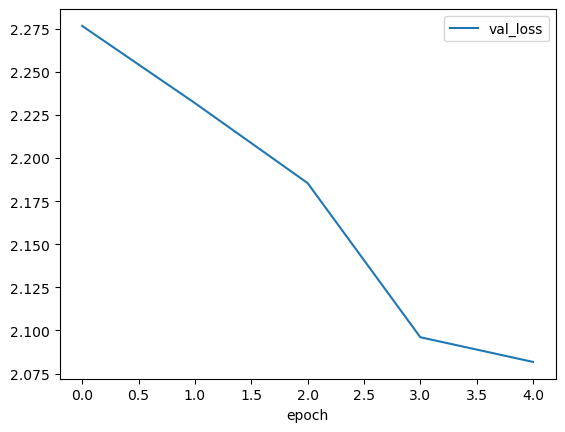

In [7]:
display(result_grid.get_dataframe())
best_results = result_grid.get_best_result("val_loss", "min")
display(best_results.metrics_dataframe)
best_results.metrics_dataframe.plot("epoch", "val_loss")

Text(0, 0.5, 'Mean Validation Loss')

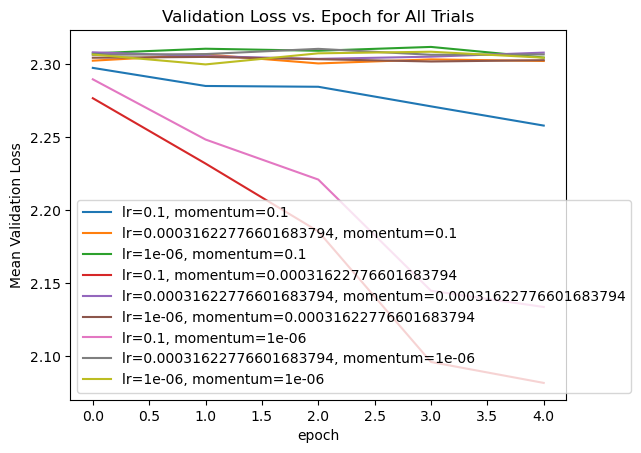

In [8]:
ax = None
for result in result_grid:
    parameters = result.config["lightning_config"]["_module_init_config"]["config"]["parameters"]
    label = f"lr={parameters['lr']}, momentum={parameters['weight_decay']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("epoch", "val_loss", label=label)
    else:
        result.metrics_dataframe.plot("epoch", "val_loss", ax=ax, label=label)
ax.set_title("Validation Loss vs. Epoch for All Trials")
ax.set_ylabel("Mean Validation Loss")